In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from textblob import TextBlob
from wordcloud import WordCloud
import re

import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sydney\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.
C:\Users\Sydney\anaconda3\envs\data101B\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sydney\anaconda3\envs\data101B\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sydney\anaconda3\envs\data101B\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a fu

In [2]:
data = pd.read_csv(r'C:\Users\Sydney\Downloads\twitter_sentiment\twitter_sent.csv',
                   encoding='latin-1', header = None)

In [3]:
data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
data.columns = ['sentiment', 'id', 'date', 'query', 'username', 'tweets']

In [5]:
data.head()

,sentiment,id,date,query,username,tweets
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#only want to train text 
data = data.drop(['id', 'date', 'query', 'username'], axis = 1)

In [7]:
lab_to_sentiment = {0:0, 4:1}
def label_decoder(label):
    return lab_to_sentiment[label]
data.sentiment = data.sentiment.apply(lambda x: label_decoder(x))
data.shape

(1600000, 2)

Text(0.5, 1.0, 'Distribution of Tweet Sentiment')

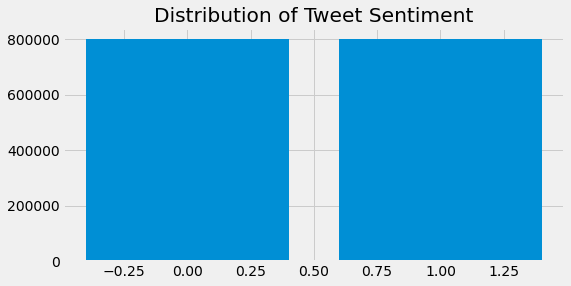

In [8]:
#how many of each do we have?
value_count = data.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(value_count.index, value_count.values)
plt.title('Distribution of Tweet Sentiment')
#evenly divided
#good because not skewed!

In [9]:
pos_data = data[data.sentiment == 1]
neg_data = data[data.sentiment == 0]
pos_data = pos_data.iloc[:int(len(pos_data)/4)]
neg_data = neg_data.iloc[:int(len(neg_data)/4)]
newData = pd.concat([pos_data, neg_data])
newData.shape

(400000, 2)

In [10]:
#stemming / lematization
#lematization - reducing words of different tenses to common form
#stemming - chopping off the ends of words and guessing 
#remove hyperlinks and mentions
#remove stopwords
#stop_words = stopwords.words('english')
#stemmer = SnowballStemmer('english')

In [11]:
def cleanText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #removing mentions
    text = re.sub(r'#', '', text) #removing hashtag symbol
    text = re.sub(r'RT[\s]+', '', text) #removing retweets
    text = re.sub(r'https?:\/\/\S+', '', text) #removing hyperlinks and whitespaces 
    text = text.lower()
    return text

newData['tweets'] = newData['tweets'].apply(cleanText)
newData.head()

,sentiment,tweets
800000,1,i love u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"thanks for the twitter add, sunisa! i got to ..."
800003,1,being sick can be really cheap when it hurts t...
800004,1,he has that effect on everyone


In [12]:
#tokenize - split string into words
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer(reduce_len=True)
tokenData = []
xData = newData['tweets'].tolist()
yData = newData['sentiment'].tolist()

for x, y in zip(xData, yData):
    if y == 1:
        tokenData.append((tk.tokenize(x), 1))
    else:
        tokenData.append((tk.tokenize(x), 0))
tokenData[:5]

[(['i', 'love', 'u', 'guys', 'r', 'the', 'best', '!', '!'], 1),
 (['im',
   'meeting',
   'up',
   'with',
   'one',
   'of',
   'my',
   'besties',
   'tonight',
   '!',
   'cant',
   'wait',
   '!',
   '!',
   '-',
   'girl',
   'talk',
   '!',
   '!'],
  1),
 (['thanks',
   'for',
   'the',
   'twitter',
   'add',
   ',',
   'sunisa',
   '!',
   'i',
   'got',
   'to',
   'meet',
   'you',
   'once',
   'at',
   'a',
   'hin',
   'show',
   'here',
   'in',
   'the',
   'dc',
   'area',
   'and',
   'you',
   'were',
   'a',
   'sweetheart',
   '.'],
  1),
 (['being',
   'sick',
   'can',
   'be',
   'really',
   'cheap',
   'when',
   'it',
   'hurts',
   'too',
   'much',
   'to',
   'eat',
   'real',
   'food',
   'plus',
   ',',
   'your',
   'friends',
   'make',
   'you',
   'soup'],
  1),
 (['he', 'has', 'that', 'effect', 'on', 'everyone'], 1)]

In [13]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

#lemmatization - reducing diff forms of word to 1 form 
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

#print(lemmatize_sentence(tokenData[0][0]))
# Previewing the WordNetLemmatizer() output
#above is a list of tuples
#tokenData = pd.DataFrame(tokenData, columns =['tokens', 'sentiment']) 
tokenData[0]

(['i', 'love', 'u', 'guys', 'r', 'the', 'best', '!', '!'], 1)

In [14]:
import re, string

from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

#function defined in order to clean text 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(tokenData[0][0]))


['love', 'guy', 'best']


In [15]:
#tokenData = pd.DataFrame(tokenData, columns=['tokens', 'sentiment'])

In [17]:
# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in tokenData:
    cleaned_tokens_list.append((remove_noise(tokens), label))

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))
    
#print('Data Prepared for model, CPU Time:', time() - start_time)

# Previewing our final (tokenized, cleaned and lemmatized) data list
final_data[:5]

[({'love': True, 'guy': True, 'best': True}, 1),
 ({'meet': True,
   'one': True,
   'besties': True,
   'tonight': True,
   'cant': True,
   'wait': True,
   'girl': True,
   'talk': True},
  1),
 ({'thanks': True,
   'twitter': True,
   'add': True,
   'sunisa': True,
   'get': True,
   'meet': True,
   'hin': True,
   'show': True,
   'area': True,
   'sweetheart': True},
  1),
 ({'sick': True,
   'really': True,
   'cheap': True,
   'hurt': True,
   'much': True,
   'eat': True,
   'real': True,
   'food': True,
   'plus': True,
   'friend': True,
   'make': True,
   'soup': True},
  1),
 ({'effect': True, 'everyone': True}, 1)]

Positive words


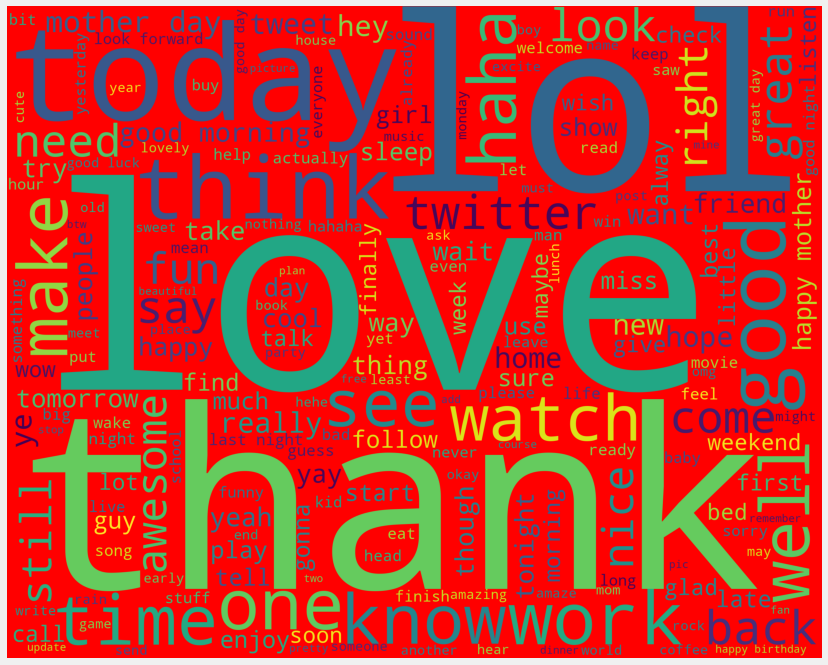

Negative words


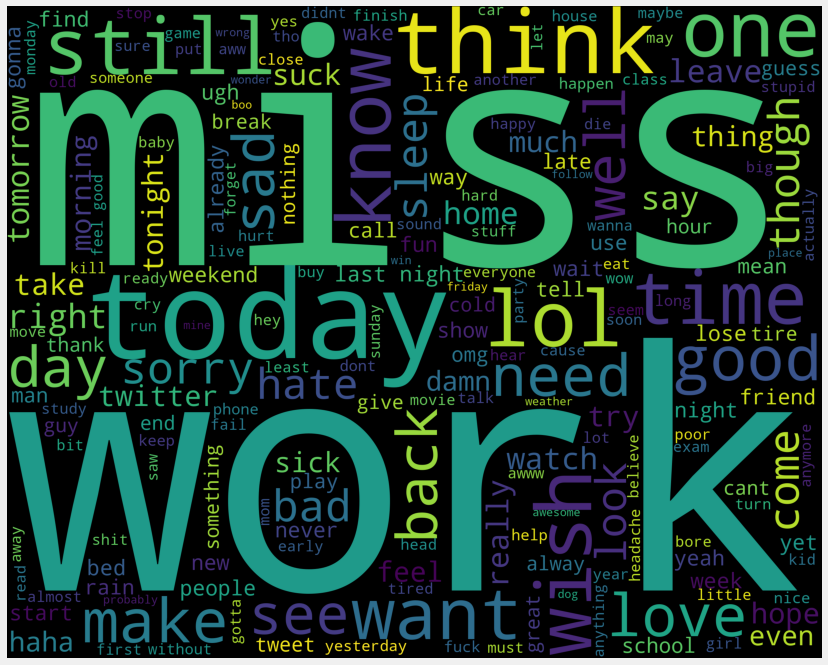

In [18]:
from wordcloud import WordCloud, STOPWORDS

positive_words = []
negative_words = []

# Separating out positive and negative words (i.e., words appearing in negative and positive tweets),
# in order to visualize each set of words independently
for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(positive_words, 'red')
print("Negative words")
wordcloud_draw(negative_words)   

In [19]:
#Building and training good word embeddings is a tremendous process 
#requiring millions of data samples and exceptional computational power. 
#Luckily for us, folks at the University of Stanford already did this for us and published 
#their results for free on their official website! Their model is called GloVe, 
#and it's going to be what we'll use in the next steps
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [20]:
##### This method will return three dictionaries:
# * word_to_index: a dictionary mapping from words to their indices in the vocabulary
# * index_to_word: dictionary mapping from indices to their corresponding words in the vocabulary
# * word_to_vec_map: dictionary mapping words to their GloVe vector representation
# Note that there are 400,001 words, with the valid indices ranging from 0 to 400,000

word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [21]:
word_to_index['hello']

176468

In [22]:
unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index
list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
print(X[:5])
print(Y[:5])

max_len: 25
[[226278. 169725.  74390.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [239785. 269953. 372306. 361859.  91041. 382320. 161844. 352214.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [357161. 368306.  46173. 372306. 160418. 239785. 179025. 329974.  58999.
  349437.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [330826. 302352.  97698. 184322. 251645. 132701. 302292. 151204. 286963.
  154049. 231458. 338210.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [133896. 141948.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.   

In [23]:
import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split

In [25]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] #50
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [26]:
# Here's my sequential model with the embedding layer, two bidirectional LSTMs, and a density layer at the end (0-1)

model = Sequential()

model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            20000050  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 256)           183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [27]:
# Use the default adam optimizer

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [29]:
len(X_train)
len(X_test)

80000

In [30]:
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)


Train on 320000 samples, validate on 80000 samples
Epoch 1/20
320000/320000 [==============================] - 603s 2ms/step - loss: 0.5527 - accuracy: 0.7126 - val_loss: 0.5151 - val_accuracy: 0.7423
Epoch 2/20
320000/320000 [==============================] - 634s 2ms/step - loss: 0.5083 - accuracy: 0.7458 - val_loss: 0.4967 - val_accuracy: 0.7530
Epoch 3/20
320000/320000 [==============================] - 625s 2ms/step - loss: 0.4869 - accuracy: 0.7601 - val_loss: 0.4865 - val_accuracy: 0.7608
Epoch 4/20
320000/320000 [==============================] - 636s 2ms/step - loss: 0.4691 - accuracy: 0.7718 - val_loss: 0.4815 - val_accuracy: 0.7647
Epoch 5/20
320000/320000 [==============================] - 626s 2ms/step - loss: 0.4510 - accuracy: 0.7831 - val_loss: 0.4875 - val_accuracy: 0.7633
Epoch 6/20
320000/320000 [==============================] - 618s 2ms/step - loss: 0.4304 - accuracy: 0.7950 - val_loss: 0.4878 - val_accuracy: 0.7656
Epoch 7/20
320000/320000 [======================

In [31]:
# Defnining a handy function in order to plot various models accuracy and loss progress

def plot_acc_loss(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

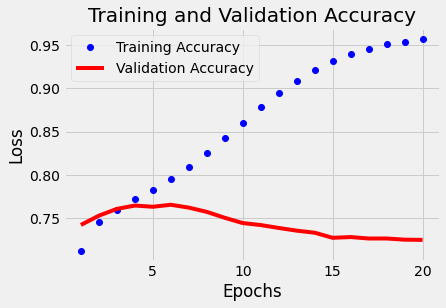

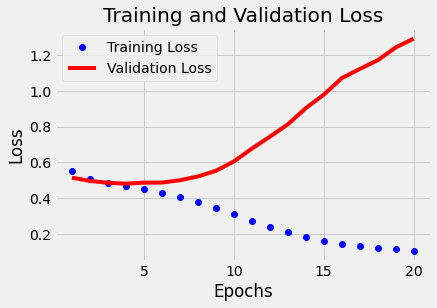

In [32]:
# Plotting the obtained training and validation loss and accuracy progressions.
plot_acc_loss(model.history)

In [80]:
keras.backend.clear_session()

model_dropout = Sequential()

model_dropout.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_dropout.add(Dropout(rate=0.4))
model_dropout.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_dropout.add(Dense(units=1, activation='sigmoid'))

model_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 50)            20000050  
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 25, 256)           183296    
_________________________________________________________________
dropout_2 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
____________________________________

In [81]:
model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [82]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Train on 320000 samples, validate on 80000 samples
Epoch 1/20
320000/320000 [==============================] - 403s 1ms/step - loss: 0.5969 - accuracy: 0.6732 - val_loss: 0.5353 - val_accuracy: 0.7279
Epoch 2/20
320000/320000 [==============================] - 441s 1ms/step - loss: 0.5621 - accuracy: 0.7051 - val_loss: 0.5265 - val_accuracy: 0.7331
Epoch 3/20
320000/320000 [==============================] - 414s 1ms/step - loss: 0.5498 - accuracy: 0.7138 - val_loss: 0.5095 - val_accuracy: 0.7454
Epoch 4/20
320000/320000 [==============================] - 403s 1ms/step - loss: 0.5402 - accuracy: 0.7213 - val_loss: 0.5023 - val_accuracy: 0.7511
Epoch 5/20
320000/320000 [==============================] - 405s 1ms/step - loss: 0.5329 - accuracy: 0.7268 - val_loss: 0.4963 - val_accuracy: 0.7552
Epoch 6/20
320000/320000 [==============================] - 404s 1ms/step - loss: 0.5268 - accuracy: 0.7311 - val_loss: 0.4941 - val_accuracy: 0.7573
Epoch 7/20
320000/320000 [=======================

In [ ]:
plot_acc_loss(model_dropout.history)

In [ ]:
model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

In [33]:
#how many unknown words in our data
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

207571

In [34]:
from collections import Counter
Counter(unks).most_common(50)

[("i'm", 32149),
 ("can't", 11370),
 ("i'l", 6284),
 ("that's", 5478),
 ("i've", 5085),
 ("he's", 1976),
 ("mother's", 1879),
 ("i'd", 1855),
 ('hahaha', 1723),
 ("we're", 1578),
 ("there's", 1425),
 ("what's", 1356),
 ("they're", 1179),
 ('lmao', 1103),
 ("we'l", 914),
 ("let's", 802),
 ('. .', 634),
 ('bday', 618),
 ('idk', 588),
 ("it'l", 587),
 ('hahah', 486),
 ('. . .', 482),
 ("how's", 440),
 ("who's", 378),
 ('asot', 363),
 ('hahahaha', 356),
 ("mom's", 333),
 (":'(", 327),
 ("ain't", 317),
 ('coky', 317),
 ('folowfriday', 314),
 ("y'al", 313),
 ("we've", 312),
 ('tweps', 312),
 (';-)', 307),
 ('thanx', 290),
 ("today's", 264),
 ('hehehe', 259),
 ('awh', 259),
 ("here's", 256),
 ("where's", 239),
 ('2morow', 235),
 ('urgh', 216),
 ('ahaha', 211),
 ("he'l", 197),
 ('b-day', 193),
 ('tomorow', 191),
 ("they'l", 191),
 ("ya'l", 187),
 ('sux', 185)]

In [35]:
# A custom function defined in order to fine-tune the cleaning of the input text.
# This function is being "upgraded" such that it performs a more thourough cleaning of the data
# in order to better fit our words embedding layer
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token


# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        # Eliminating the token if it is a link
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens


# Prevewing the remove_noise() output
print(remove_noise(tokenData[0][0]))

['i', 'love', 'you', 'guys', 'are', 'the', 'best']


In [36]:
unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

# Removing noise from all the data, using the newly defined function
for tokens, label in tokenData:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

#print('Removed Noise, CPU Time:', time() - start_time)
#start_time = time()

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)


X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))


for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    
#print('Data Prepared for model, CPU Time:', time() - start_time)


print(X[:5])
print(Y[:5])

max_len: 79
[[185457. 226278. 394475. 169754.  58997. 357266.  74390.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.]
 [187631. 239792. 373317. 388711. 269953. 268046. 254258. 372306. 361859.
   91041. 382320. 161844. 352214.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.

In [37]:
unk = word_to_index['unk']

n_unk_words = 0

for x in X:
    for y in x:
        if y == unk:
            n_unk_words += 1

n_unk_words

131053

In [38]:
from collections import Counter
Counter(unks).most_common(50)

[(':/', 672),
 ('(:', 452),
 ('shouldnt', 429),
 ('. .', 426),
 ('asot', 363),
 (":'(", 327),
 ('folowfriday', 314),
 ('tweps', 312),
 (';-)', 307),
 ('->', 288),
 ('iï', 278),
 ("today's", 264),
 ('d:', 261),
 ('hehehe', 259),
 ('awh', 259),
 ("weren't", 257),
 ("here's", 256),
 ("where's", 239),
 ('2morow', 235),
 ('urgh', 216),
 ('_x', 215),
 ('ahaha', 211),
 ("he'l", 197),
 ('tomorow', 191),
 ("they'l", 191),
 ('8:', 189),
 ('sux', 185),
 ('_carter', 179),
 ('hadnt', 178),
 ('tmrw', 177),
 ('retwet', 174),
 ('bleh', 174),
 ('yey', 172),
 ('probs', 169),
 ('delongeday', 168),
 ('<-', 167),
 ('theyve', 164),
 ('twiterverse', 160),
 ('awsome', 150),
 ("friend's", 148),
 ('lï', 146),
 ('itï', 142),
 ('cï', 139),
 ("everyone's", 138),
 ("g'night", 137),
 ('twiterland', 137),
 ('omfg', 137),
 ('damnit', 137),
 ("she'l", 135),
 ('=/', 134)]

In [39]:
keras.backend.clear_session()

model_clean_data = Sequential()

model_clean_data.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model_clean_data.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model_clean_data.add(Dense(units=1, activation='sigmoid'))

model_clean_data.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 79, 50)            20000050  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 79, 256)           183296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 20,577,843
Trainable params: 577,793
Non-trainable params: 20,000,050
_________________________________________________________________


In [40]:
model_clean_data.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
len(X_train)
#319360
len(X_test)
#79841

79860

In [42]:
model_clean_data.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 20, batch_size = 128, shuffle=True)

Train on 319436 samples, validate on 79860 samples
Epoch 1/20
319436/319436 [==============================] - 3422s 11ms/step - loss: 0.5217 - accuracy: 0.7367 - val_loss: 0.4787 - val_accuracy: 0.7687
Epoch 2/20
319436/319436 [==============================] - 3599s 11ms/step - loss: 0.4551 - accuracy: 0.7835 - val_loss: 0.4415 - val_accuracy: 0.7927
Epoch 3/20
319436/319436 [==============================] - 3682s 12ms/step - loss: 0.4260 - accuracy: 0.8012 - val_loss: 0.4405 - val_accuracy: 0.7976
Epoch 4/20
319436/319436 [==============================] - 3905s 12ms/step - loss: 0.4035 - accuracy: 0.8142 - val_loss: 0.4173 - val_accuracy: 0.8071
Epoch 5/20
319436/319436 [==============================] - 4490s 14ms/step - loss: 0.3822 - accuracy: 0.8262 - val_loss: 0.4213 - val_accuracy: 0.8059
Epoch 6/20
319436/319436 [==============================] - 2801s 9ms/step - loss: 0.3600 - accuracy: 0.8383 - val_loss: 0.4218 - val_accuracy: 0.8083
Epoch 7/20
319436/319436 [============

In [ ]:
history = model_clean_data.history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

In [ ]:
def i_to_sentence(I):
    sentence = ""
    for i in I:
        if i:
            sentence += index_to_word[int(i)] + " "
        else:
            break
    return sentence

In [ ]:
C = 0

pred = model_clean_data.predict(X_test)

for i in range(len(X_test)):
    final_pred = 1 if pred[i] > 0.5 else 0
    
    if(final_pred != Y_test[i]):
        print('Expected sentiment: ' + str(int(Y_test[i])) + '. Input: ' + i_to_sentence(X_test[i]))
        C += 1
        
    if C > 100:
        break

## classification logistic regression b.o.w